In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def my_DLT(pts1: np.array, pts2: np.array) -> np.array:
  # Add homogeneous coordinates
  _, y = pts1.shape

  if y == 2:
    pts1 = np.column_stack((pts1, np.ones(len(pts1))))
    pts2 = np.column_stack((pts2, np.ones(len(pts2))))
  
  # Compute matrix A
  A = []
  for i in range(len(pts1)):
    A.append([0, 0, 0, -(pts2[i, 2]*pts1[i, 0]), -(pts2[i, 2]*pts1[i, 1]), -(pts2[i, 2]*pts1[i, 2]), pts2[i, 1]*pts1[i, 0], pts2[i, 1]*pts1[i, 1], pts2[i, 1]*pts1[i, 2]])
    A.append([pts2[i, 2]*pts1[i, 0], pts2[i, 2]*pts1[i, 1], pts2[i, 2]*pts1[i, 2], 0, 0, 0, -(pts2[i, 0]*pts1[i, 0]), -(pts2[i, 0]*pts1[i, 1]), -(pts2[i, 0]*pts1[i, 2])])
  

  # Perform SVD(A) = U.S.Vt to estimate the homography
  _, _, C = np.linalg.svd(A)

  
  # Reshape last column of V as the homography matrix
  H_matrix = C[-1].reshape((3,3))
  
  return H_matrix


def normalize_points(points):
    # Calculate centroid
    x_c, y_c = np.mean(points, axis=0)

    # Calculate the average distance of the points having the centroid as origin
    dist = 0
    for p in points:
      dist+= np.sqrt(np.power((x_c - p[0]), 2) + np.power((y_c - p[1]), 2))
    
    avr_dist = dist/len(points)

    # Define the scale to have the average distance as sqrt(2)
    scale = np.sqrt(2)/avr_dist
    
    # Define the normalization matrix (similar transformation)
    S = np.array([[scale, 0, 0],
                  [0, scale, 0],
                  [0,   0  , 1]])
    
    O = np.array([[1, 0, -x_c],
                  [0, 1, -y_c], 
                  [0, 0,   1 ]])
    
    T = np.dot(S, O)
    
    # Normalize points
    pts = np.column_stack((points, np.ones(len(points))))

    norm_pts = np.dot(T, pts.T).T
    
    return T, norm_pts

def my_homography(pts1,pts2):

    # Normalize points  
    T1, norm_pts1 = normalize_points(pts1)
    T2, norm_pts2 = normalize_points(pts2)
    
    # Perform DLT and obtan normalized matrix
    H_til = my_DLT(norm_pts1, norm_pts2)
    
    # Denormalize the homography matrix
    H = np.dot(np.linalg.inv(T2), np.dot(H_til, T1))
    
    return H

In [1]:
import numpy as np

def ransac_homography(pts1, pts2, num_iterations, threshold):
    best_inliers = []
    best_homography = None

    for _ in range(num_iterations):
        # Randomly sample 4 point correspondences
        indices = np.random.choice(len(pts1), 4, replace=False)
        sample_pts1 = pts1[indices]
        sample_pts2 = pts2[indices]

        # Compute homography using the sampled points
        H = my_homography(sample_pts1, sample_pts2)

        # Compute the reprojection error for all points
        projected_pts2 = np.dot(H, np.column_stack((pts1, np.ones(len(pts1)))).T).T
        projected_pts2 /= projected_pts2[:, 2].reshape((-1, 1))
        errors = np.linalg.norm(projected_pts2[:, :2] - pts2, axis=1)

        # Count inliers (points with errors below threshold)
        inliers = np.where(errors < threshold)[0]

        # Update best homography and inliers if the current model is better
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_homography = H

    # Refit homography using all inliers
    best_homography = my_homography(pts1[best_inliers], pts2[best_inliers])

    return best_homography, best_inliers

In [2]:
import numpy as np

def ransac(pts1, pts2, num_iterations, threshold):
    best_inliers = []
    best_H = None

    for _ in range(num_iterations):
        # Randomly select a minimum set of points
        random_indices = np.random.choice(len(pts1), 4, replace=False)
        sample_pts1 = pts1[random_indices]
        sample_pts2 = pts2[random_indices]

        # Compute homography using the sample points
        H = my_homography(sample_pts1, sample_pts2)

        # Find inliers based on the threshold
        inliers = []
        for i in range(len(pts1)):
            transformed_pt = np.dot(H, np.append(pts1[i], 1))
            transformed_pt /= transformed_pt[2]
            error = np.linalg.norm(transformed_pt[:2] - pts2[i])
            if error < threshold:
                inliers.append(i)

        # Update the best model if the current one has more inliers
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H

    # Refine the model using all the inliers
    refined_H = my_homography(pts1[best_inliers], pts2[best_inliers])

    return refined_H


In [9]:

im1 = cv2.resize(cv2.imread('Fig1.jpg'), (400,300))
im2 = cv2.resize(cv2.imread('Fig2.jpg'), (400,300))

Text(0.5, 1.0, 'Fig2')

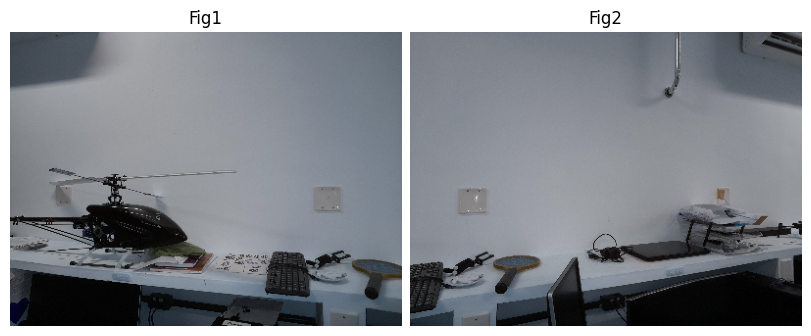

In [10]:
fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(8, 8))
axs[0].imshow(np.uint8(im1),cmap='gray')
axs[0].axis('off')
axs[0].set_title("Fig1")

axs[1].imshow(np.uint8(im2),cmap='gray',vmin=0,vmax=255)
axs[1].axis('off')
axs[1].set_title("Fig2")

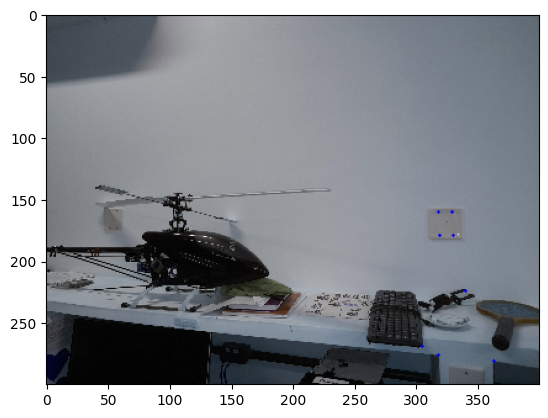

In [11]:
im1 = cv2.resize(cv2.imread('Fig1.jpg'), (400,300))
A_fig1 = cv2.circle(im1, (318, 160), radius=1, color=(0, 0, 255), thickness=-1)
B_fig1 = cv2.circle(im1, (329, 160), radius=1, color=(0, 0, 255), thickness=-1)
C_fig1 = cv2.circle(im1, (319, 179), radius=1, color=(0, 0, 255), thickness=-1)
D_fig1 = cv2.circle(im1, (330, 179), radius=1, color=(0, 0, 255), thickness=-1)
E_fig1 = cv2.circle(im1, (318, 276), radius=1, color=(0, 0, 255), thickness=-1)
F_fig1 = cv2.circle(im1, (363, 281), radius=1, color=(0, 0, 255), thickness=-1)
G_fig1 = cv2.circle(im1, (305, 269), radius=1, color=(0, 0, 255), thickness=-1)
H_fig1 = cv2.circle(im1, (340, 224), radius=1, color=(0, 0, 255), thickness=-1)

P_fig1 = np.array([[318, 160], [329, 160], [319, 179], [330, 179], [318, 276], [363, 281], [305, 269], [340, 224]])
plt.imshow(im1)

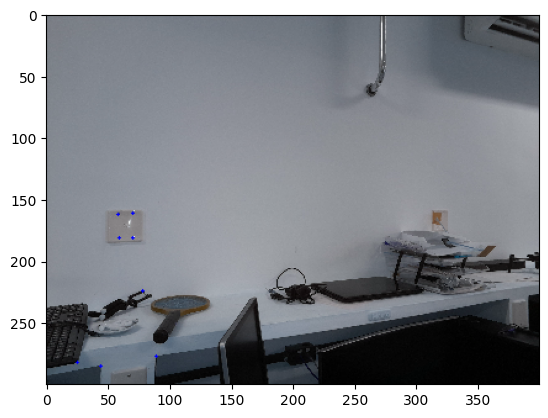

In [12]:
im2 = cv2.resize(cv2.imread('Fig2.jpg'), (400,300))

A_fig2 = cv2.circle(im2, (58, 162), radius=1, color=(0, 0, 255), thickness=-1)
B_fig2 = cv2.circle(im2, (70, 161), radius=1, color=(0, 0, 255), thickness=-1)
C_fig2 = cv2.circle(im2, (59, 181), radius=1, color=(0, 0, 255), thickness=-1)
D_fig2 = cv2.circle(im2, (70, 181), radius=1, color=(0, 0, 255), thickness=-1)
E_fig2 = cv2.circle(im2, (44, 285), radius=1, color=(0, 0, 255), thickness=-1)
F_fig2 = cv2.circle(im2, (89, 277), radius=1, color=(0, 0, 255), thickness=-1)
G_fig2 = cv2.circle(im2, (25, 282), radius=1, color=(0, 0, 255), thickness=-1)
H_fig2 = cv2.circle(im2, (78, 224), radius=1, color=(0, 0, 255), thickness=-1)

P_fig2 = np.array([[58, 162], [70, 161], [59, 181], [70, 181], [44, 285], [89, 277], [25, 282], [78, 224]])
plt.imshow(im2)

Text(0.5, 1.0, 'Fig2')

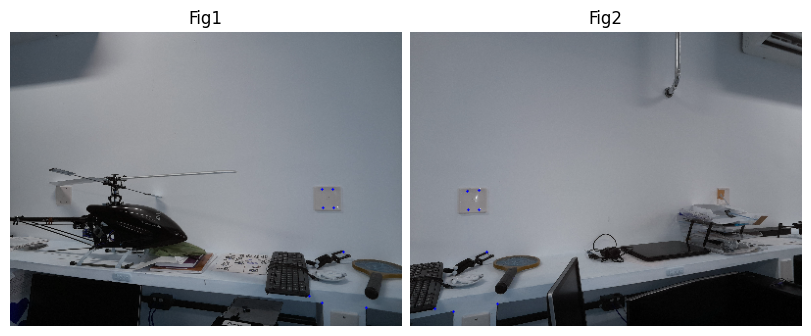

In [13]:
fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(8, 8))
axs[0].imshow(np.uint8(im1),cmap='gray')
axs[0].axis('off')
axs[0].set_title("Fig1")

axs[1].imshow(np.uint8(im2),cmap='gray',vmin=0,vmax=255)
axs[1].axis('off')
axs[1].set_title("Fig2")

In [14]:
H = my_homography(P_fig1, P_fig2)

(-0.5, 399.5, 299.5, -0.5)

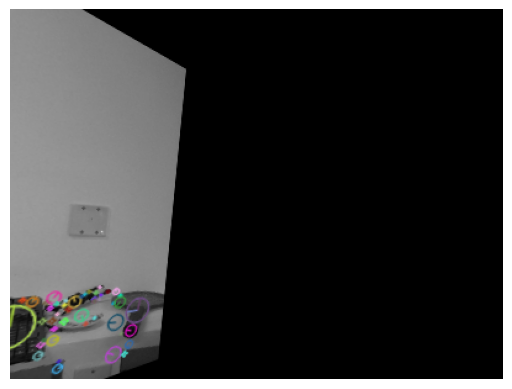

In [21]:
img4 = cv2.warpPerspective(im1, H, (im2.shape[1],im2.shape[0])) 
plt.imshow(np.uint8(img4),cmap='gray',vmin=0,vmax=255)
plt.axis('off')

In [16]:
x = []
y = []

for i in range(im1.shape[0]):
    for j in range(im1.shape[1]):
        p = np.array([i, j, 1])
        p_n = np.dot(H, p.T)
        p_n = np.round(p_n/p_n[2])
        x.append(p_n[0])
        y.append(p_n[1])

In [17]:
len(x)

120000

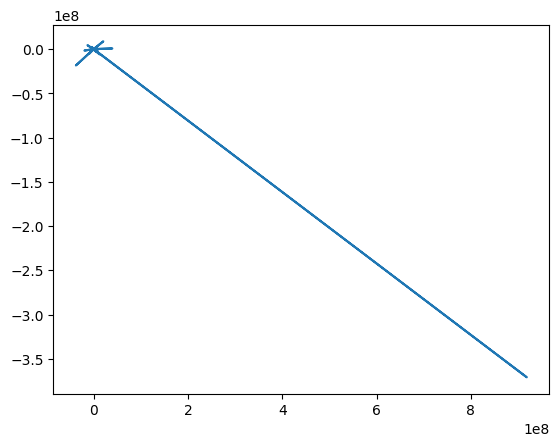

In [18]:
plt.plot(x, y)

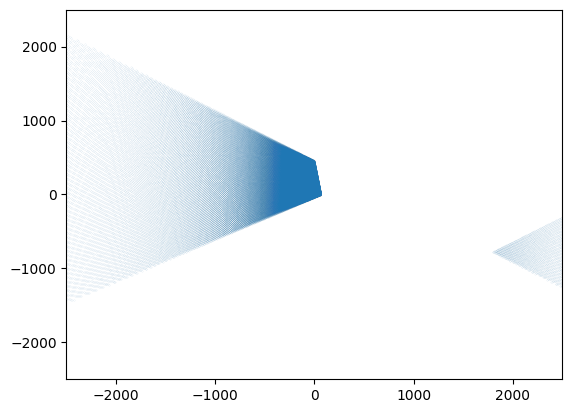

In [19]:
plt.scatter(x, y, s = 0.001)
plt.xlim(-2500,  2500)
plt.ylim(-2500, 2500)
plt.show()

### SIFT

In [20]:
gray= cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
 
# Applying SIFT detector
sift = cv2.SIFT_create()
kp = sift.detect(gray, None)
 
# Marking the keypoint on the image using circles
img=cv2.drawKeypoints(gray ,
                      kp ,
                      im1 ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
cv2.imwrite('image-with-keypoints.jpg', img)

True